In [1]:
import os
import sys
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import numpy as np
from torchsummary import summary
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torchvision.transforms as tf
import cv2
from PIL import Image
from tqdm.auto import tqdm

In [2]:
sys.path.append('/openpose')
from model import PoseEstimationWithMobileNet
from include import CocoKeypoints
import transforms

In [3]:
n_epoch = 100
lr = 1e-3
batch = 16

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PoseEstimationWithMobileNet().to(device)
model = nn.DataParallel(model).to(device)


criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay= 1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min')

In [5]:
preprocess = transforms.Compose([
        transforms.Normalize(),
        transforms.RandomApply(transforms.HFlip(), 0.5),
        transforms.RescaleRelative(),
        transforms.Crop(368),
        transforms.CenterPad(368),
    ])

In [6]:
data_dir = "/var/lib/docker/openpose/coco"
ann_train_dir = [os.path.join(data_dir, 'annotations', item) 
                 for item in ['person_keypoints_val2017.json']]
ann_val_dir = os.path.join(data_dir, 'images/val2017')

image_transform = None

datas = [CocoKeypoints(
            root=ann_val_dir,
            annFile=item,
            preprocess=preprocess,
            image_transform=image_transform,
            target_transforms=image_transform, 
        ) for item in ann_train_dir]

# summary(model, image.shape)

loading annotations into memory...
Done (t=0.41s)
creating index...
index created!
filter for keypoint annotations ...
... done.
Images: 2346


max:2.640000104904175, min:-2.1179039478302


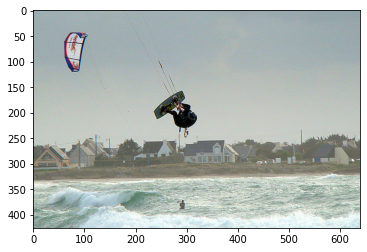

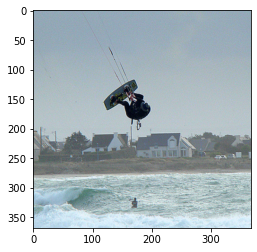

In [7]:
data = datas[0]
(image, heatmaps, pafs), filepath = data[0]
# print(f"Shape of original image = {im.shape}")
# print(f"Shape of heatmap = {heatmap.shape}")
# print(f"Shape of paf = {paf.shape}")

# reference image
fig = plt.figure()
ref_image = Image.open(filepath)
plt.imshow(ref_image)

# image from dataloader
im = image.numpy()
im = np.transpose(im, (1, 2, 0))
max_value_i = np.max(im)
min_value_i = np.min(im)
print(f"max:{max_value_i}, min:{min_value_i}")
n_im = (im - min_value_i)/(max_value_i-min_value_i)
fig = plt.figure()
plt.imshow(n_im)

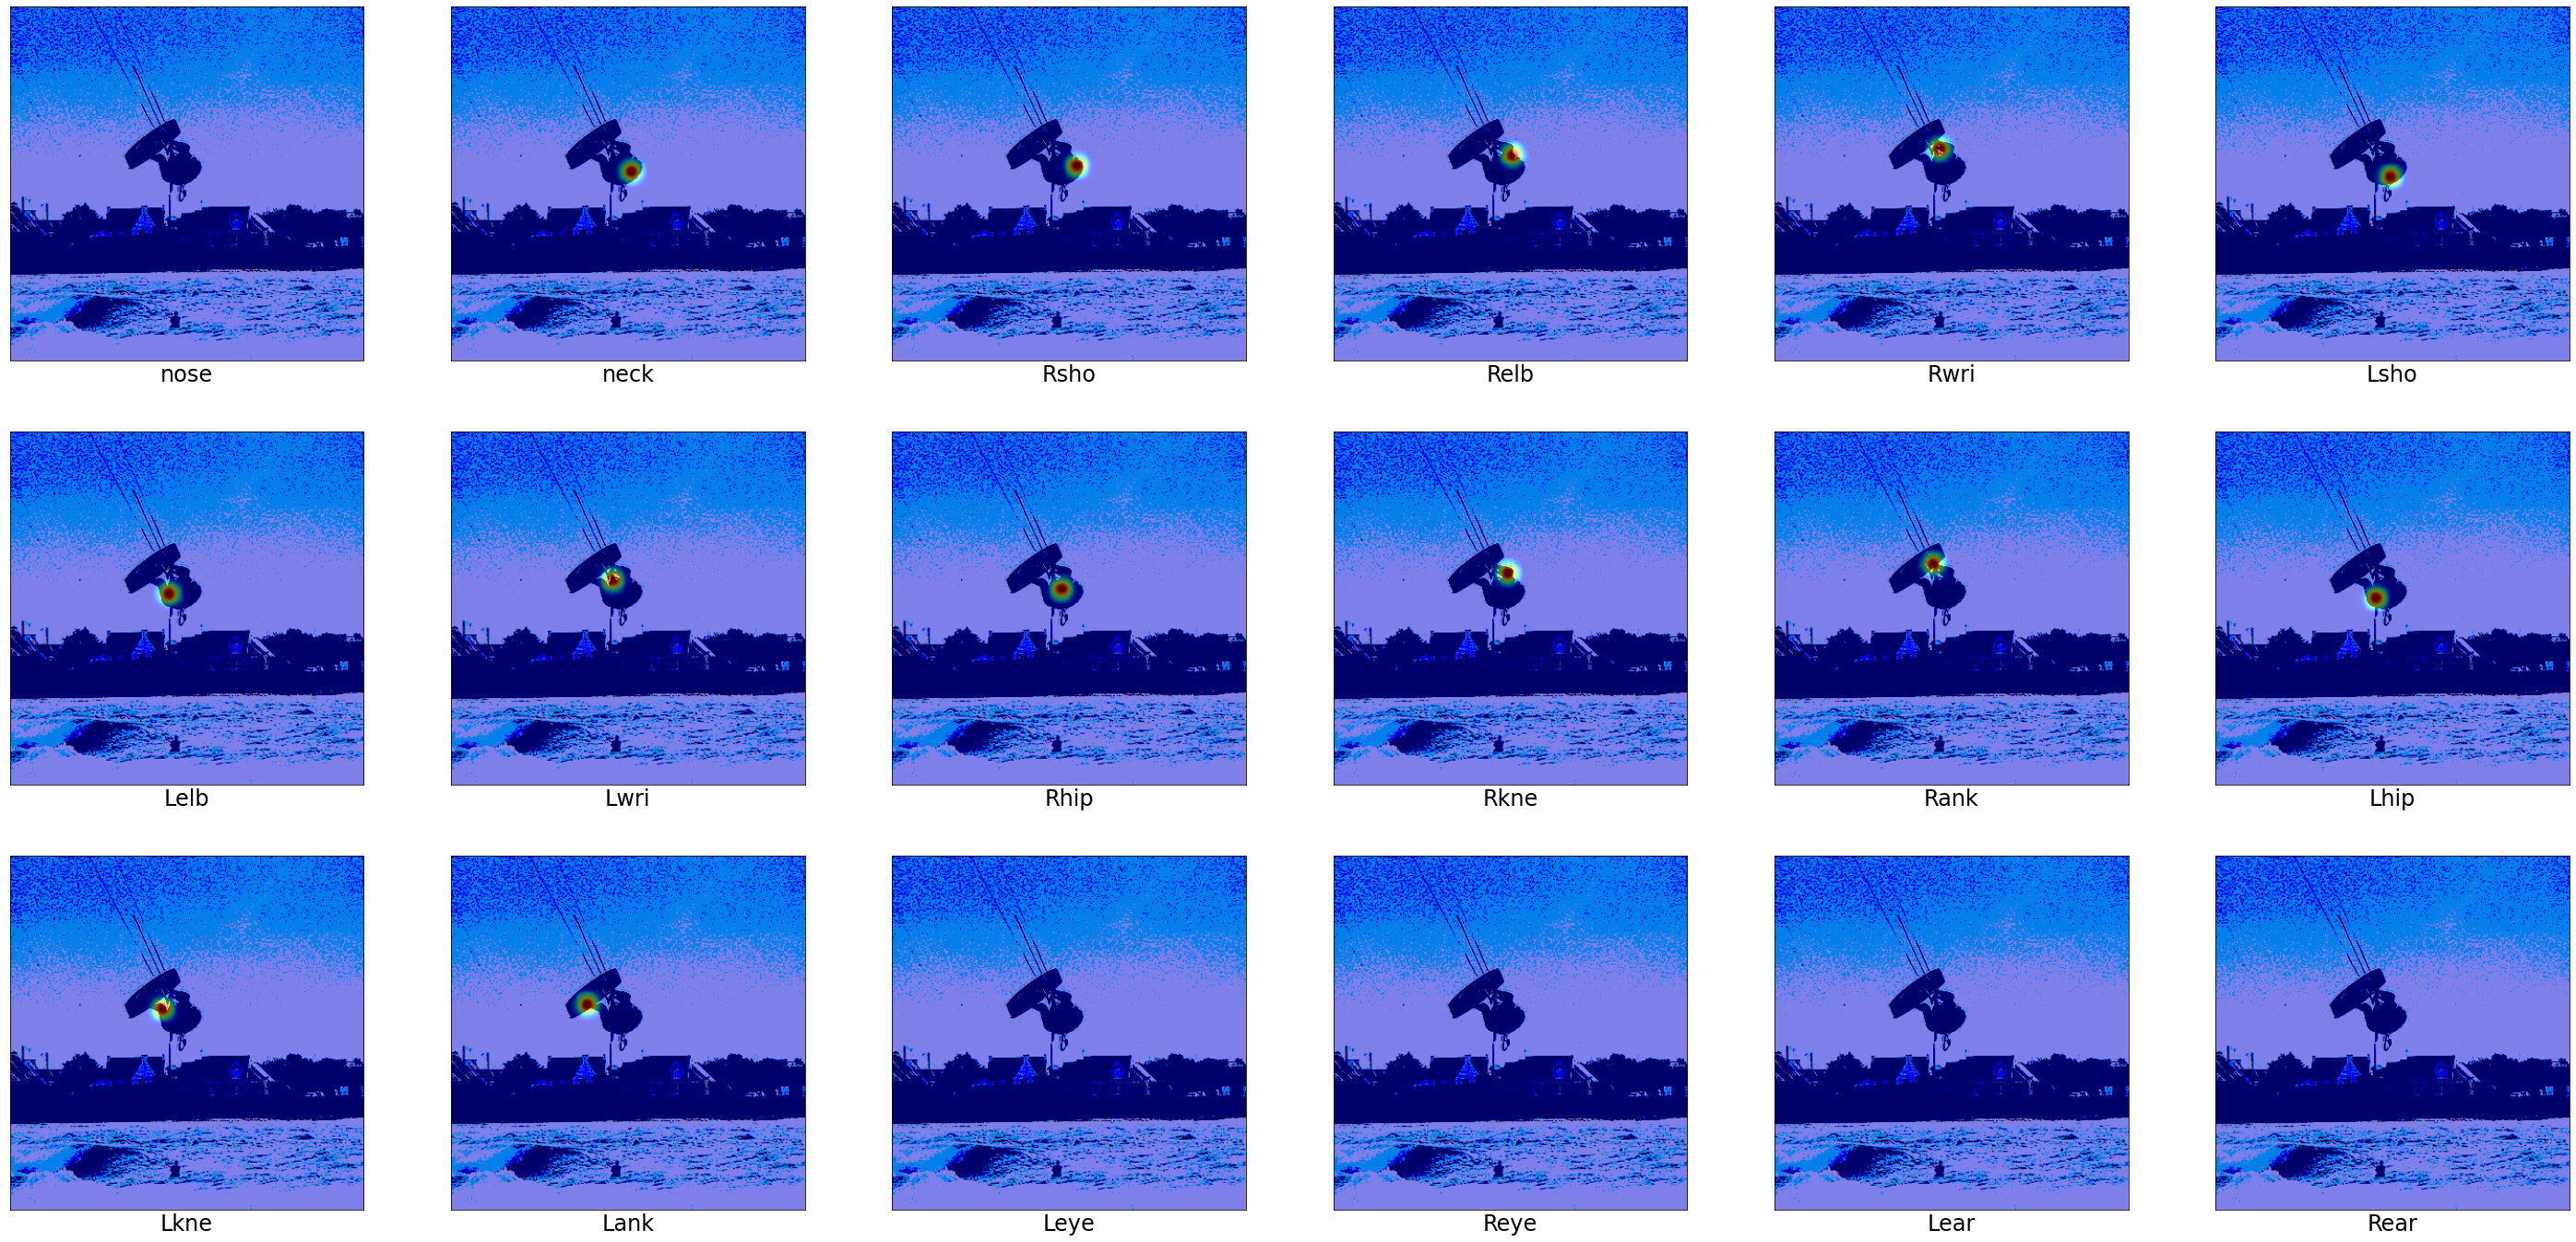

In [8]:
heatmap = heatmaps.numpy()
heatmap = np.transpose(heatmap, (1, 2, 0))
heatmap = cv2.resize(heatmap, (0, 0), fx=8, fy=8, interpolation=cv2.INTER_CUBIC)
max_value = np.max(heatmap)
min_value = np.min(heatmap)

fig = plt.figure(figsize = (50, 24))
im_ = Image.fromarray(im.astype(np.uint8)*255)
im_ = im_.convert('RGB')
label = ['nose', 'neck', 'Rsho', 'Relb', 'Rwri', 'Lsho', 'Lelb', 'Lwri', 'Rhip', 
         'Rkne', 'Rank', 'Lhip', 'Lkne', 'Lank', 'Leye', 'Reye', 'Lear', 'Rear', 'pt19'] 
for i in range(18):
    vis_img = (heatmap[:, :, i]-min_value)/max_value
    vis_img = Image.fromarray(np.uint8(cm.jet(vis_img) * 255))
    vis_img = vis_img.convert('RGB') 
    vis_img = Image.blend(im_, vis_img, 0.5)
    vis_img = np.array(vis_img)
    plt.subplot(3,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(vis_img)
    plt.xlabel(label[i], fontsize=24)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

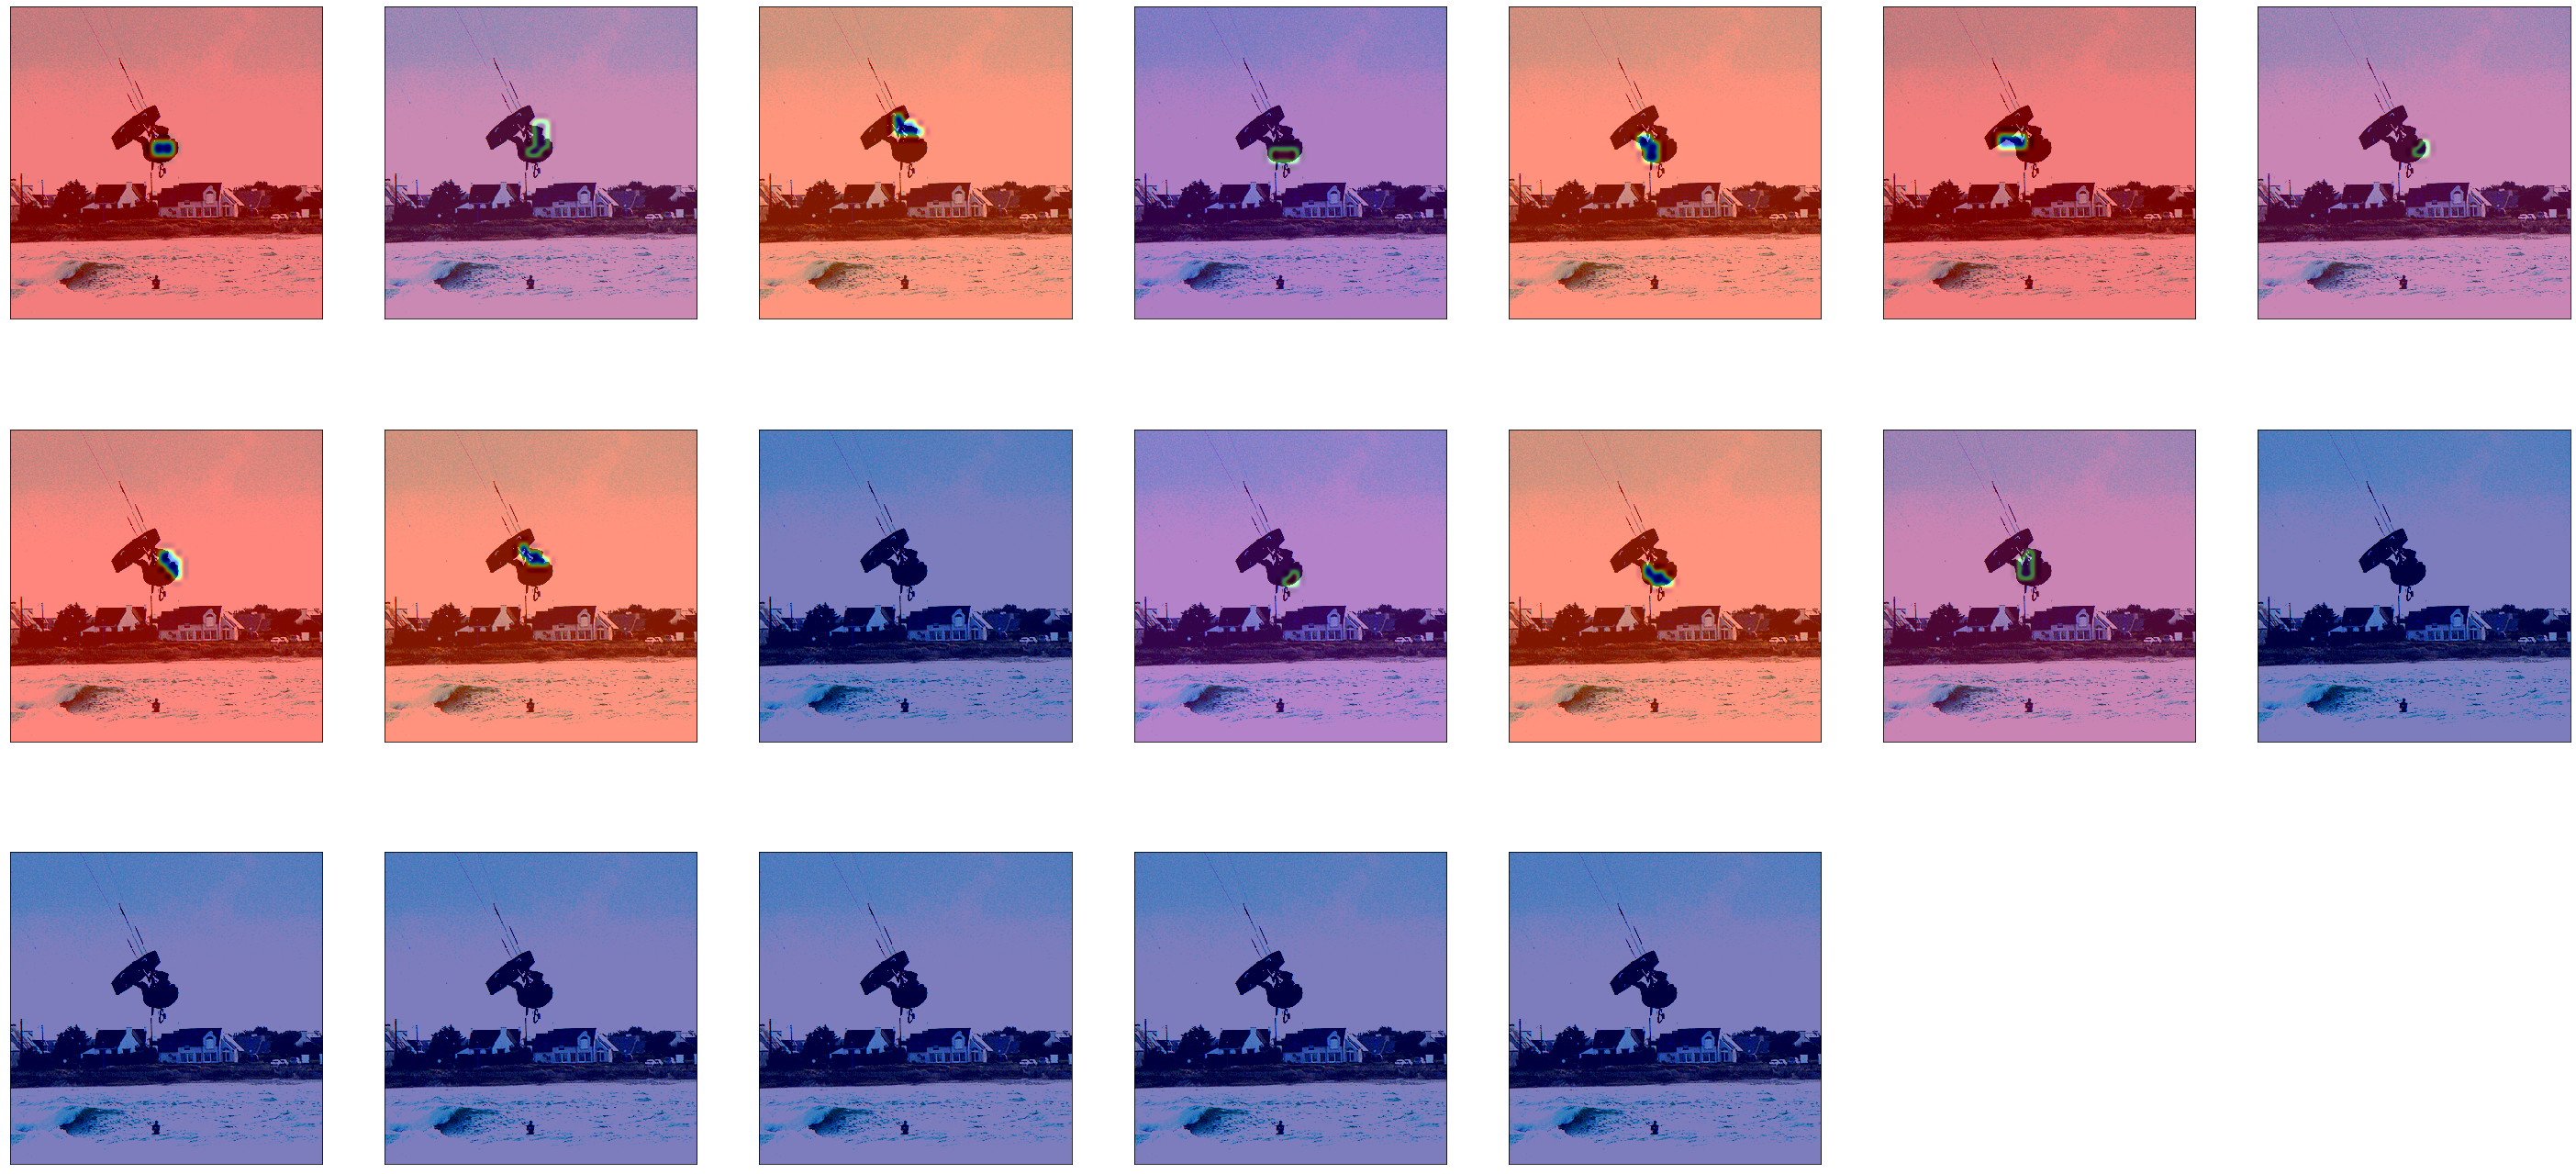

In [9]:
paf = pafs.numpy()
paf = np.transpose(paf, (1, 2, 0))
paf = cv2.resize(paf, (0, 0), fx=8, fy=8, interpolation=cv2.INTER_CUBIC)

fig = plt.figure(figsize = (50, 24))
max_value = np.max(paf)
min_value = np.min(paf)
for i in range(19):
    vis_img_x = (paf[:, :, i*2]-min_value)/max_value 
    vis_img_y = (paf[:, :, i*2+1]-min_value)/max_value /255   
    plt.subplot(3,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(im, interpolation='nearest')
    plt.imshow(vis_img_x, cmap=plt.cm.jet, alpha=0.3)
    plt.imshow(vis_img_y, cmap=plt.cm.jet, alpha=0.3)

In [10]:
summary(model, image.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 184, 184]             864
       BatchNorm2d-2         [-1, 32, 184, 184]              64
              ReLU-3         [-1, 32, 184, 184]               0
            Conv2d-4         [-1, 32, 184, 184]             288
            Conv2d-5         [-1, 32, 184, 184]             864
       BatchNorm2d-6         [-1, 32, 184, 184]              64
       BatchNorm2d-7         [-1, 32, 184, 184]              64
              ReLU-8         [-1, 32, 184, 184]               0
              ReLU-9         [-1, 32, 184, 184]               0
           Conv2d-10         [-1, 32, 184, 184]             288
      BatchNorm2d-11         [-1, 32, 184, 184]              64
           Conv2d-12         [-1, 64, 184, 184]           2,048
             ReLU-13         [-1, 32, 184, 184]               0
      BatchNorm2d-14         [-1, 64, 1

/usr/local/lib/python3.6/dist-packages/torchsummary/torchsummary.py:93: RuntimeWarning: overflow encountered in long_scalars
  total_output += np.prod(summary[layer]["output_shape"])


In [11]:
dataset = torch.utils.data.ConcatDataset(datas)

n_train = 1600
n_val = 400
train_data, val_data, _ = torch.utils.data.random_split(dataset, 
                                                (n_train, n_val, len(dataset)-n_train-n_val))
 
train_loader = torch.utils.data.DataLoader(
            train_data, 
            batch_size = batch, 
            shuffle = True,
            num_workers = 0,
            drop_last = True,
            )
val_loader = torch.utils.data.DataLoader(
            val_data, 
            batch_size = batch,
            shuffle = True,
            num_workers = 0,
            drop_last = True,
            )

In [12]:
%load_ext tensorboard
import datetime
from torch.utils.tensorboard import SummaryWriter
print(os.getcwd())
log_dir = '/openpose/runs/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
summary = SummaryWriter('/openpose/runs')
# !kill 643
%tensorboard --logdir /openpose/runs --port 6004 --bind_all

/tf


In [13]:
ti = time.time()
save_dir = "./best_model_wi"

for epoch in tqdm(range(n_epoch)):
    best_val_loss = np.inf
    train_tot_loss = 0
    val_tot_loss = 0
    
    ######### TRAIN ########
    model.train()
    i = 0
    for i, ((images, heatmaps, pafs), filepath) in enumerate(train_loader):
        i = i+1
        images = images.to(device)
        heatmaps = heatmaps.to(device)
        pafs = pafs.to(device)
    
        stages_output = model(images)
        paf = stages_output[-1].to(device=device, dtype=torch.long)
        heatmap = stages_output[-2].to(device=device, dtype=torch.long)
    
        train_loss = criterion(heatmaps, heatmap) + criterion(pafs, paf)
        
        optimizer.zero_grad()
        train_loss.requires_grad = True
        train_loss.backward()
        optimizer.step()
        train_tot_loss += train_loss.item()

#         if i==1:
#             break

    ######## VALIDATION ########
    with torch.no_grad():
        model.eval()
        for i, ((images, heatmaps, pafs), filepath) in enumerate(val_loader):
            i = i+1
            images = images.to(device)
            heatmaps = heatmaps.to(device)
            pafs = pafs.to(device)
            
            stages_output = model(images)
            paf = stages_output[-1].to(device=device, dtype=torch.long)
            heatmap = stages_output[-2].to(device=device, dtype=torch.long)
            
            val_loss = criterion(heatmaps, heatmap) + criterion(pafs, paf)
            val_tot_loss += val_loss.item()
            
#             if i==2:
#                 break

        scheduler.step(val_loss)
        if val_loss<best_val_loss:
            torch.save(model.state_dict(), save_dir)
            
    summary.add_scalar('train_loss', train_tot_loss, epoch)
    summary.add_scalar('val_loss', val_tot_loss, epoch)
            
    # print status every 10 epoch
    if epoch % 10 == 0 or epoch == n_epoch-1:
        ti2 = time.time()
        ti_ = ti2-ti
        print(f"for {epoch}epoch, {ti_}sec elapsed")

summary.close()

  0%|          | 0/100 [00:00<?, ?it/s]

for 0epoch, 116.1200966835022sec elapsed
for 10epoch, 1158.956357717514sec elapsed
for 20epoch, 2204.23291683197sec elapsed
for 30epoch, 3252.162309408188sec elapsed
for 40epoch, 4298.694045305252sec elapsed
for 50epoch, 5342.759193658829sec elapsed
for 60epoch, 6383.935100078583sec elapsed
for 70epoch, 7429.134806871414sec elapsed
for 80epoch, 8473.630964517593sec elapsed
for 90epoch, 9518.96206855774sec elapsed
for 99epoch, 10459.93107509613sec elapsed
